## **Imports**

In [14]:
import os
import random
import shutil

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision.models import resnet34, ResNet34_Weights
from torchvision import transforms, datasets
import torch.optim as optim
from torchvision.transforms.functional import to_pil_image
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    precision_recall_curve, 
    average_precision_score,
    roc_curve, 
    roc_auc_score,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    confusion_matrix,
    classification_report,
    precision_recall_curve
)

from tensorboardX import SummaryWriter


print(f"Check CUDA availability: {torch.cuda.is_available()}")
print(f"Check CUDA device count: {torch.cuda.device_count()}")

torch.cuda.manual_seed_all(42)

# Device Agnostic Code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'\nUsing {device}')


Check CUDA availability: True
Check CUDA device count: 1

Using cuda


## **Hyperparameters**

DATA_PATH -> Update this to the path containing `chest_xray` folder after downloading and extracting from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia for reproduceability.

In [3]:
# Hyperparameters
BATCH_SIZE   = 32
IMAGE_SIZE   = 224
IN_CHANNELS  = 3
NUM_CLASSES  = 2
LEARNING_RATE = 0.001
MAX_LEARNING_RATE = 0.001
MIN_LEARNING_RATE = 0.0001
EPOCHS = 10
WEIGHT_DECAY = 1e-4

# Other Params
DATA_PATH = rf"C:\Users\aniru\Desktop\UCF\Coursework\CAP5516 - MIC\Assignments\A1\chest_xray"   

## **Data Preprocessing**

#### **Merge val into train**

In [12]:
# Merge val into train before proceeding to preprocessing
train_dir = os.path.join(DATA_PATH, "train")
val_dir = os.path.join(DATA_PATH, "val")
test_dir = os.path.join(DATA_PATH, "test")

def count_images_in_folder(folder_path):
    images_count_by_folder = {} 

    if not os.path.exists(folder_path):
        print(f"Warning: Folder '{folder_path}' does not exist.")
        return images_count_by_folder
    
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)

        if not os.path.isdir(subfolder_path):
            print(f"Skipping non-directory: {subfolder_path}")
            continue
        
        try:
            image_count = 0  
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):  
                    image_count += 1
            
            images_count_by_folder[subfolder] = image_count  
            # print(f"Found {image_count} images in '{subfolder_path}'.")

        except FileNotFoundError:
            print(f"Error: Subfolder '{subfolder_path}' not found.")
            continue
        except Exception as e:
            print(f"Unexpected error while accessing '{subfolder_path}': {e}")
    
    return images_count_by_folder

train_images_by_folder = count_images_in_folder(train_dir)
val_images_by_folder = count_images_in_folder(val_dir)
test_images_by_folder = count_images_in_folder(test_dir)

print("\nImages in 'train' folder:")
for subfolder, count in train_images_by_folder.items():
    print(f"  - {subfolder}: {count} images")

print("\nImages in 'val' folder:")
for subfolder, count in val_images_by_folder.items():
    print(f"  - {subfolder}: {count} images")

print("\nImages in 'test' folder:")
for subfolder, count in test_images_by_folder.items():
    print(f"  - {subfolder}: {count} images")


    
if not os.path.exists(val_dir):
    print("\nValidation folder does not exist. The dataset may have been merged already or extracted incorrectly.")
else:
    for subfolder in os.listdir(val_dir):
        val_subfolder_path = os.path.join(val_dir, subfolder)
        train_subfolder_path = os.path.join(train_dir, subfolder)

        if not os.path.exists(train_subfolder_path):
            print(f"\nSkipping '{subfolder}' as it does not exist in train.")
            continue

        try:
            for file in os.listdir(val_subfolder_path):
                src_path = os.path.join(val_subfolder_path, file)
                dst_path = os.path.join(train_subfolder_path, file)

                if os.path.exists(dst_path):
                    print(f"\nFile '{file}' already exists in train/{subfolder}. Skipping.")
                else:
                    shutil.move(src_path, dst_path)

            print(f"\nSuccessfully merged '{subfolder}' from val to train.")

        except Exception as e:
            print(f"\nError while moving files from '{subfolder}': {e}")

    if not os.listdir(val_dir):
        try:
            shutil.rmtree(val_dir)
            print("\nValidation folder removed successfully.")
        except Exception as e:
            print(f"\nError deleting validation folder: {e}")
    else:
        print("\nSome files might not have been moved. Check manually.")

print("\nProcess completed.")



Images in 'train' folder:
  - NORMAL: 1349 images
  - PNEUMONIA: 3883 images

Images in 'val' folder:

Images in 'test' folder:
  - NORMAL: 234 images
  - PNEUMONIA: 390 images

Validation folder does not exist. The dataset may have been merged already or extracted incorrectly.

Process completed.


#### **Calculate Mean and Standard Deviation on train**

In [4]:
def calculate_mean_std(data_path):
    transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_path, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
    
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    
    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    return mean.numpy(), std.numpy()

train_mean, train_std = calculate_mean_std(os.path.join(DATA_PATH, "train"))
print(f"Mean: {train_mean}, Std: {train_std}")  

Mean: [0.48233032 0.48233032 0.48233032], Std: [0.22163819 0.22163819 0.22163819]


#### **Total Images in train and test after merging**

In [5]:
train_len_normal = len(os.listdir(os.path.join(DATA_PATH, 'train', 'NORMAL')))
train_len_pneum = len(os.listdir(os.path.join(DATA_PATH, 'train', 'PNEUMONIA')))

test_len_normal = len(os.listdir(os.path.join(DATA_PATH, 'test', 'NORMAL')))
test_len_pneum = len(os.listdir(os.path.join(DATA_PATH, 'test', 'PNEUMONIA')))

print(f"Number of training samples: {train_len_normal}")
print(f"Number of training samples: {train_len_pneum}")

print(f"Number of test samples: {test_len_normal}")
print(f"Number of test samples: {test_len_pneum}")

Number of training samples: 1350
Number of training samples: 3884
Number of test samples: 234
Number of test samples: 390


#### **Initilize Stratified 5-Fold Cross Validation and Weighted Random Sampler**

In [ ]:
# Stratified K-Fold
full_dataset = datasets.ImageFolder(os.path.join(DATA_PATH, "train"),                               
    transform=transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=train_mean, std=train_std)
    ]))

labels = [label for _, label in full_dataset.samples]

k_folds = 5

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

folds = []

for fold, (train_idx, val_idx) in enumerate(skf.split(full_dataset, labels)):
    folds.append((train_idx, val_idx))
    print(f"Fold {fold+1}: Train={len(train_idx)}, Val={len(val_idx)}")
    

# Weighted Random Sampler

def get_sampler(dataset, indices):
    class_counts = {}
    for idx in indices:
        _, label = dataset.samples[idx]
        class_counts[label] = class_counts.get(label, 0) + 1
    
    # Assigning weights inversely
    weights = [1.0 / class_counts[label] for _, label in dataset.samples]
    subset_weights = [weights[i] for i in indices]
    
    return WeightedRandomSampler(
        weights=subset_weights,
        num_samples=len(indices),
        replacement=True
    )
    

Fold 1: Train=4185, Val=1047
Fold 2: Train=4185, Val=1047
Fold 3: Train=4186, Val=1046
Fold 4: Train=4186, Val=1046
Fold 5: Train=4186, Val=1046


#### **Create DataLoaders for each Fold with Augmentation**

1. **Train Transforms:**: RandomRotation, RandomHorizontalFlip, Resize, ToTensor, Normalize(mean and std of train)
2. **Val Transforms:**: Resize, ToTensor, Normalize
3. **Train Transforms:**: Same as Val Transforms

In [7]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

fold_loaders = []

for fold, (train_idx, val_idx) in enumerate(folds):
    # Subsets
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    
    # Sampler for balancing
    train_sampler = get_sampler(full_dataset, train_idx)
    val_sampler = get_sampler(full_dataset, val_idx)
    
    # DataLoaders
    train_loader = DataLoader(
        train_subset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
    )
    
    val_loader = DataLoader(
        val_subset,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )
    
    fold_loaders.append((train_loader, val_loader))
    print(f"Fold {fold+1}: Train={len(train_idx)}, Val={len(val_idx)}")
    
test_dataset = datasets.ImageFolder(
    os.path.join(DATA_PATH, "test"),
    transform=val_transforms  
)

test_loader = DataLoader(test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

Fold 1: Train=4185, Val=1047
Fold 2: Train=4185, Val=1047
Fold 3: Train=4186, Val=1046
Fold 4: Train=4186, Val=1046
Fold 5: Train=4186, Val=1046


#### **Visualize Class Distribution**

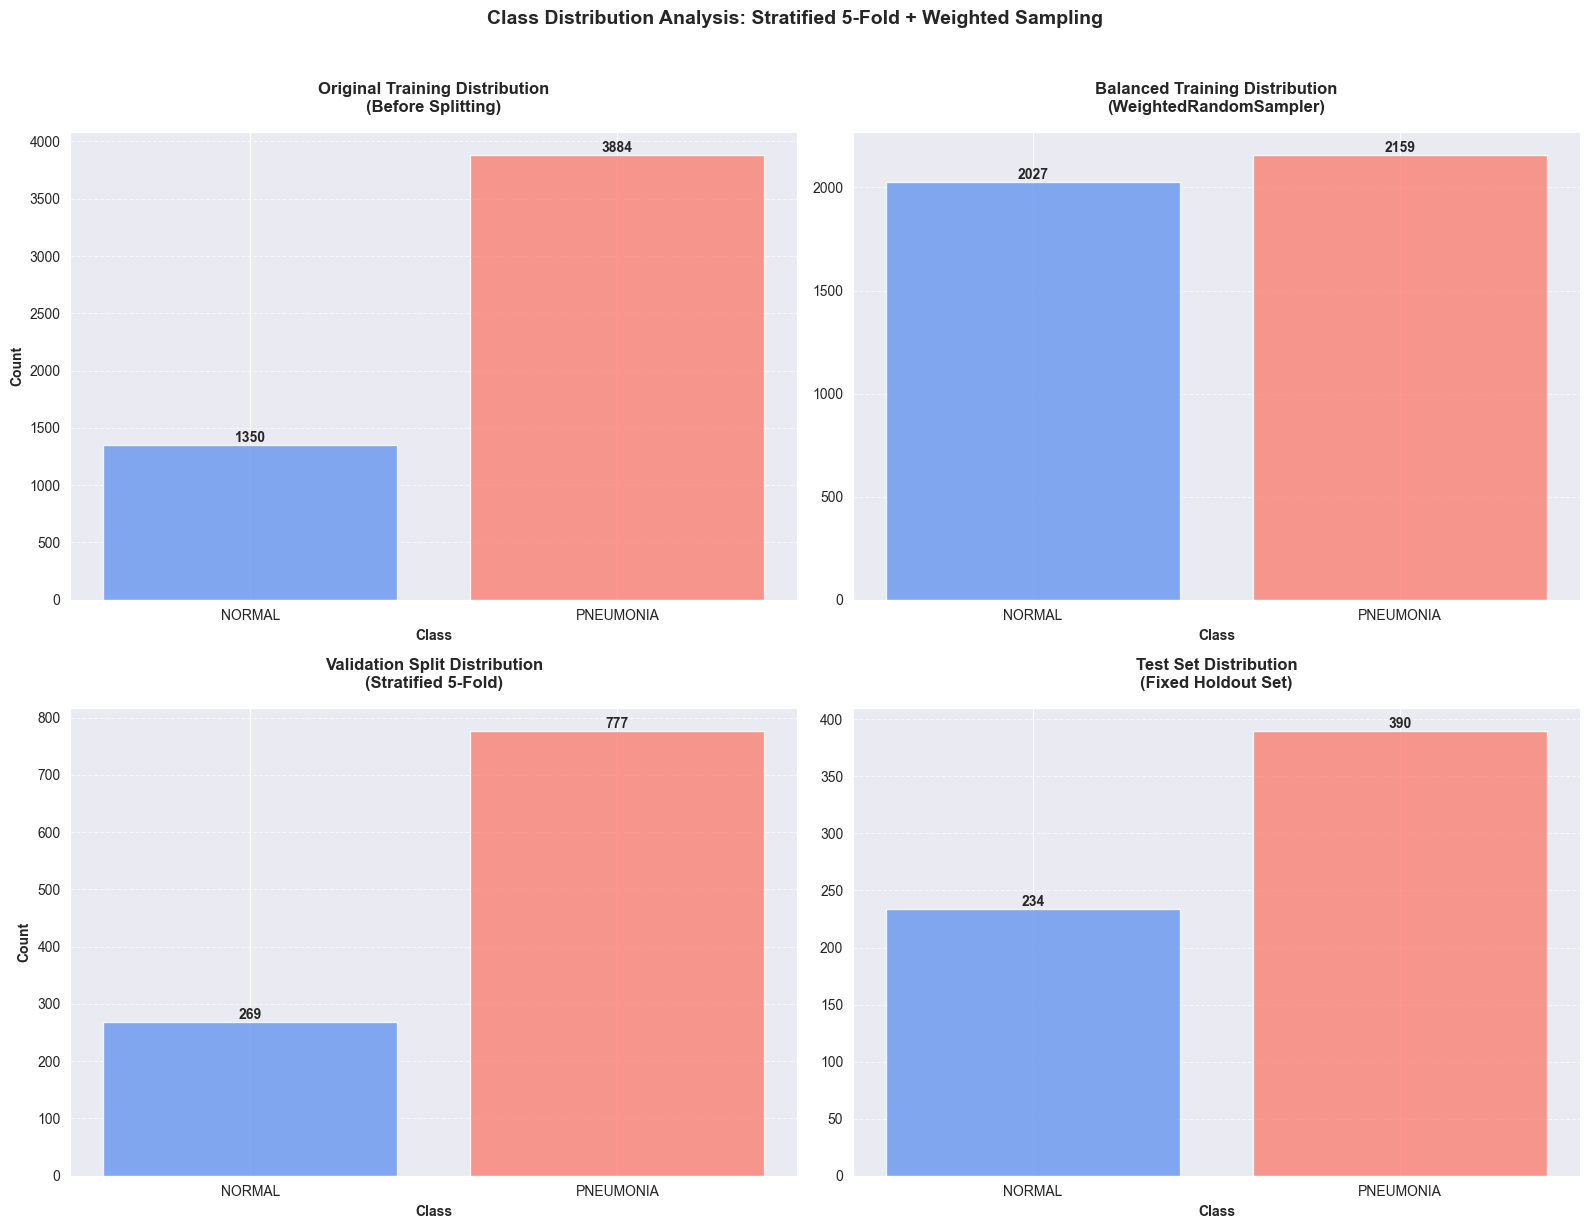

In [ ]:
def plot_class_distribution(original_counts, train_loader, val_loader, test_counts, class_names):
    sns.set_style("darkgrid")
    
    # Calculate counts after WeightedRandomSampler
    balanced_train_counts = {cls: 0 for cls in class_names}
    val_split_counts = {cls: 0 for cls in class_names}
    
    for _, labels in train_loader:
        for label in labels:
            cls = class_names[label]
            balanced_train_counts[cls] += 1
            
    for _, labels in val_loader:
        for label in labels:
            cls = class_names[label]
            val_split_counts[cls] += 1

    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    axs[0,0].bar(original_counts.keys(), original_counts.values(), 
                 color=['cornflowerblue', 'salmon'], alpha=0.8)
    axs[0,0].set_title('Original Training Distribution\n(Before Splitting)', 
                      fontsize=12, pad=15, fontweight='bold')
    axs[0,0].set_ylabel('Count', fontweight='bold')
    
    axs[0,1].bar(balanced_train_counts.keys(), balanced_train_counts.values(),
                 color=['cornflowerblue', 'salmon'], alpha=0.8)
    axs[0,1].set_title('Balanced Training Distribution\n(WeightedRandomSampler)', 
                      fontsize=12, pad=15, fontweight='bold')
    
    axs[1,0].bar(val_split_counts.keys(), val_split_counts.values(),
                color=['cornflowerblue', 'salmon'], alpha=0.8)
    axs[1,0].set_title('Validation Split Distribution\n(Stratified 5-Fold)', 
                      fontsize=12, pad=15, fontweight='bold')
    axs[1,0].set_ylabel('Count', fontweight='bold')
    
    axs[1,1].bar(test_counts.keys(), test_counts.values(),
                color=['cornflowerblue', 'salmon'], alpha=0.8)
    axs[1,1].set_title('Test Set Distribution\n(Fixed Holdout Set)', 
                      fontsize=12, pad=15, fontweight='bold')

    # Formatting
    for ax in axs.flat:
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.set_xlabel('Class', fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
    for p in axs[0,0].containers:
        axs[0,0].bar_label(p, fontsize=10, fontweight='bold')
        
    for p in axs[0,1].containers:
        axs[0,1].bar_label(p, fontsize=10, fontweight='bold')
        
    for p in axs[1,0].containers:
        axs[1,0].bar_label(p, fontsize=10, fontweight='bold')
        
    for p in axs[1,1].containers:
        axs[1,1].bar_label(p, fontsize=10, fontweight='bold')
        
    plt.suptitle('Class Distribution Analysis: Stratified 5-Fold + Weighted Sampling', 
                y=1.02, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

class_names = full_dataset.classes  

original_counts = {f'NORMAL': train_len_normal, 'PNEUMONIA': train_len_pneum} 
test_counts = {'NORMAL': test_len_normal, 'PNEUMONIA': test_len_pneum}   

train_loader, val_loader = fold_loaders[4] 

plot_class_distribution(original_counts, train_loader, val_loader, test_counts, class_names)

#### **Visualize Random Images**

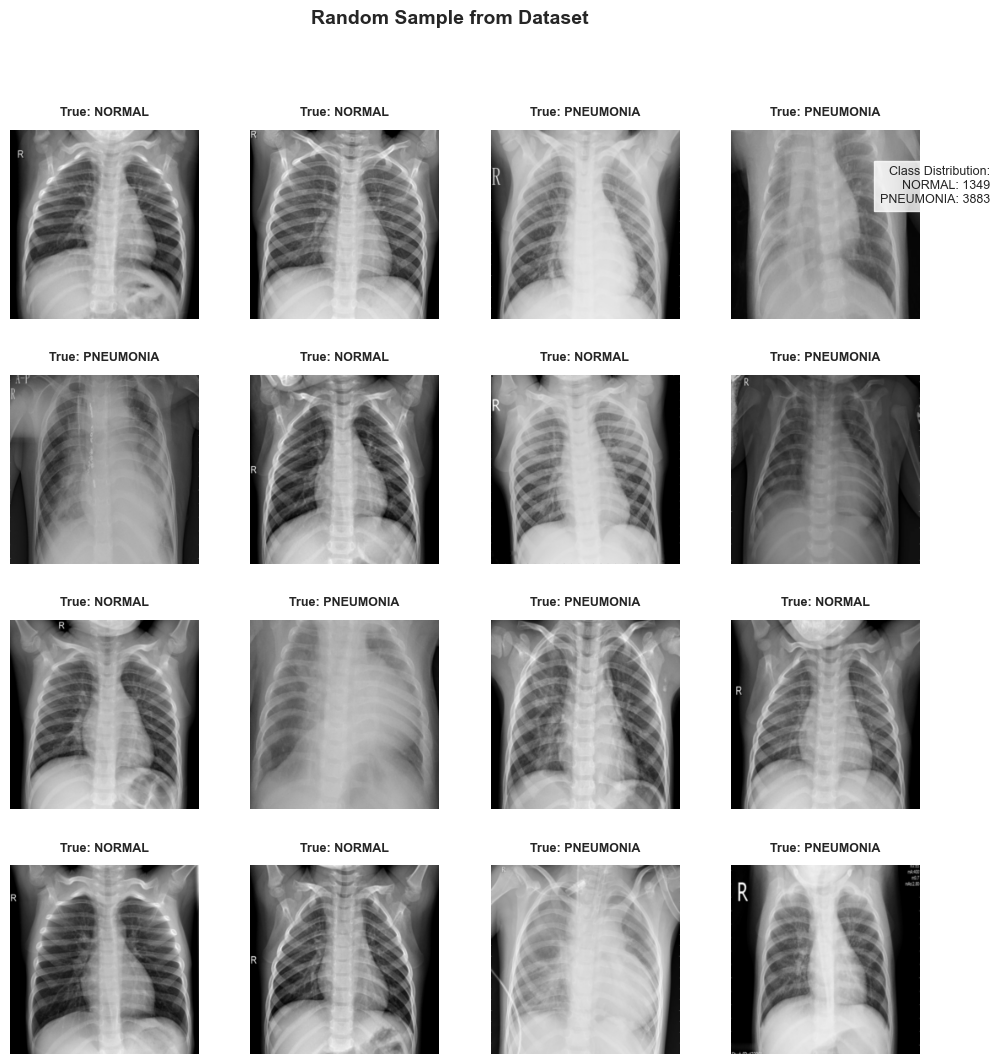

In [9]:
def plot_random_images_with_labels(dataset, num_images=9, seed=None, mean=[], std=[], show_distribution=True, plot_title=True):

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

    # Handle cases where requested images exceed dataset size
    num_images = min(num_images, len(dataset))
    
    if show_distribution:
        class_counts = {cls: 0 for cls in dataset.classes}
        for _, label in dataset.samples:
            class_counts[dataset.classes[label]] += 1

    denorm = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )

    rows = int(np.sqrt(num_images))
    cols = int(np.ceil(num_images / rows))
    
    fig = plt.figure(figsize=(cols*3, rows*3))
    gs = fig.add_gridspec(rows, cols, hspace=0.3, wspace=0.15)

    random_indices = random.sample(range(len(dataset)), num_images)
    for i, idx in enumerate(random_indices):
        ax = fig.add_subplot(gs[i])
        
        image, label = dataset[idx]
        image = denorm(image).clamp(0, 1) 
        image = image.permute(1, 2, 0).cpu().numpy()
        
        # Plot with enhanced annotations
        ax.imshow(image)
        ax.set_title(
            f"True: {dataset.classes[label]}",fontsize=9, pad=10,fontweight='bold')
        ax.axis('off')

    # Add class distribution overlay
    if show_distribution:
        dist_text = "\n".join([f"{k}: {v}" for k, v in class_counts.items()])
        fig.text(0.95, 0.85, f"Class Distribution:\n{dist_text}",
                 ha='right', va='top',bbox=dict(facecolor='white', alpha=0.8),fontsize=9)

    # Add main title
    if plot_title:
        fig.suptitle(
            f"Random Sample from {getattr(dataset, 'split', 'Dataset')}", ha='center', va='top', fontsize=14, fontweight='bold')

    plt.show()

# Usage example
plot_random_images_with_labels(
    full_dataset,
    num_images=16,
    seed=42,
    show_distribution=True,
    mean=train_mean,
    std=train_std
)

## **Essential METHODS Initialization**

#### **Training Loop**

In [12]:
## TRAINING LOOP AND VALIDATION LOOP
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Train Step
def train_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in tqdm(train_loader, desc="\tTraining",  colour="green"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        scheduler.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct_preds / total_preds

    return avg_loss, accuracy

# Val Step
def validate_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="\tValidating",  colour="green"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct_preds / total_preds
    return avg_loss, accuracy


#### **Methods to Plot Various Metrics**

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(cm, test_set):
    classes = test_set.classes
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=True,
                xticklabels=classes, yticklabels=classes,
                annot_kws={"size": 10, "weight": 'bold'})
    plt.title("Confusion Matrix", fontsize=20, fontweight="bold")
    plt.xlabel("Predicted", fontsize=15, fontweight="bold")
    plt.ylabel("Ground Truth", fontsize=15, fontweight="bold")
    plt.xticks(fontsize=10, weight='bold')
    plt.yticks(fontsize=10, weight='bold')
    plt.show()

def plot_metric_curves():
    sns.set_style("darkgrid")

    fig, ax = plt.subplots(1, 2, figsize=(13, 6))

    ax[0].plot(range(1, len(train_acc_history)+1), train_acc_history, label='Train Accuracy', color='cornflowerblue')
    ax[0].plot(range(1, len(val_acc_history)+1), val_acc_history, label='Val Accuracy', color='orange')
    ax[0].set_title("Accuracy Curve", fontsize=20, fontweight="bold")
    ax[0].set_xlabel("Epochs", fontsize=15, fontweight="bold")
    ax[0].set_ylabel("Accuracy (%)", fontsize=15, fontweight="bold")
    ax[0].legend()

    ax[1].plot(range(1, len(train_loss_history)+1), train_loss_history, label='Train Loss', color='cornflowerblue')
    ax[1].plot(range(1, len(val_loss_history)+1), val_loss_history, label='Val Loss', color='orange')
    ax[1].set_title("Loss Curve", fontsize=20, fontweight="bold")
    ax[1].set_xlabel("Epochs", fontsize=15, fontweight="bold")
    ax[1].set_ylabel("Loss", fontsize=15, fontweight="bold")
    ax[1].legend()

    plt.tight_layout()
    plt.show()
    
def plot_classification_curves(y_true, y_probs, class_names):
    sns.set_style("darkgrid")
    fig, ax= plt.subplots(1, 2, figsize=(16, 6))
    
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    roc_auc = roc_auc_score(y_true, y_probs[:, 1])
    RocCurveDisplay.from_predictions(y_true, y_probs[:, 1], ax=ax[0], color='darkorange')
    ax[0].set_title(f'ROC Curve (AUC = {roc_auc:.2f})', fontsize=14, fontweight='bold')
    ax[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax[0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes, linestyle='--', color='gray', alpha=0.7)
    ax[0].grid(linestyle='--', alpha=0.5)
    
    precision, recall, _ = precision_recall_curve(y_true, y_probs[:, 1])
    avg_precision = average_precision_score(y_true, y_probs[:, 1])
    PrecisionRecallDisplay.from_predictions(y_true, y_probs[:, 1], ax=ax[1], color='darkgreen')
    ax[1].set_title(f'Precision-Recall Curve (AP = {avg_precision:.2f})', fontsize=14, fontweight='bold')
    ax[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax[1].plot([0, 1], [0.5, 0.5], transform=ax[1].transAxes, linestyle='--', color='gray', alpha=0.7)
    ax[1].grid(linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def plot_class_metrics(cm, class_names):
    metrics = {}
    for i, cls in enumerate(class_names):
        tp = cm[i,i]
        fp = cm[:,i].sum() - tp
        fn = cm[i,:].sum() - tp
        
        precision = tp / (tp + fp + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
        
        metrics[cls] = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(class_names))
    width = 0.25
    
    for i, (metric, color) in enumerate(zip(['precision', 'recall', 'f1'], 
                                          ['#1f77b4', '#ff7f0e', '#2ca02c'])):
        values = [metrics[cls][metric] for cls in class_names]
        ax.bar(x + i*width, values, width, label=metric.capitalize(), color=color)
    
    ax.set_xticks(x + width)
    ax.set_xticklabels(class_names, fontsize=12)
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Class-wise Performance Metrics', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', frameon=True)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

#### **Test Model**

In [ ]:
def test_model(model, test_loader, test_set):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    print("\n\n------------------------------ TESTING ------------------------------\n\n")

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="TESTING", colour="green"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays for scikit-learn
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_probs = np.array(all_probs)

    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=test_set.classes)
    print("\n------------------------------ CLASSIFICATION REPORT ------------------------------\n", cr)

    print("------------------------------ CONFUSION MATRIX ------------------------------\n")
    plot_confusion_matrix(cm, test_set)

    # print("\n------------------------------ CLASS-WISE METRICS ------------------------------\n")
    # plot_class_metrics(cm, test_set.classes)

    print("\n------------------------------ CLASSIFICATION CURVES ------------------------------\n")
    plot_classification_curves(y_true, y_probs, test_set.classes)

#### **Methods to Visualize Predictions and Misclassified Samples**

In [ ]:
# Visulize a predictions
def visualize_predictions(model, loader):
    model.eval()
    inputs, labels = next(iter(loader))  
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, 5, figsize=(15, 7))
    rand_imgs = np.random.choice(len(inputs), 5, replace=False)
    for i, idx in enumerate(rand_imgs):
        ax = axes[i]
        ax.imshow(inputs[idx].cpu().numpy().transpose(1, 2, 0))  
        # Green for correct, Red for incorrect
        if predicted[idx] == labels[idx]:
            ax.set_title(f"Pred: {predicted[idx].item()} / True: {labels[idx].item()}", color='green')
        else:
            ax.set_title(f"Pred: {predicted[idx].item()} / True: {labels[idx].item()}", color='red')
        ax.axis('off')

    plt.show()


def visualize_misclassified(model, loader, device):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified.append((inputs[i].cpu(), predicted[i].item(), labels[i].item()))
            if len(misclassified) >= 10:
                break

    if not misclassified:
        print("No misclassified samples found.")
        return
    if len(misclassified) < 10:
        print(f"Only {len(misclassified)} misclassified samples found.")

    print(f"Total misclassified: {len(misclassified)}")

    if len(misclassified) > 5:
        print("Showing 5 random misclassified samples.")
        num_images = min(len(misclassified), 5)
    else:
        num_images = len(misclassified)
    selected_samples = np.random.choice(len(misclassified), num_images, replace=False)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 7))
    if num_images == 1:
        axes = [axes]
    for i, idx in enumerate(selected_samples):
        img, pred, true = misclassified[idx]
        ax = axes[i]
        ax.imshow(img.numpy().transpose(1, 2, 0))  # Convert CHW to HWC
        ax.set_title(f"Pred: {pred} / True: {true}", color="red")
        ax.axis('off')

    plt.show()

## **TASK 1.1**
Training the model - **ResNet-34** from scratch (trying out and using `nn.init.xavier_uniform_(m.weight)` for random weight initialization) using the training X-ray images.
* Using `nn.CrossEntropyLoss()` as the loss function.
* Using `optim.AdamW() ` as the optimizer with a weight decay of `WEIGHT_DECAY` and a learning rate of `LEARNING_RATE`.
* Using `CosineAnnealingLR()` as the learning rate scheduler.

#### **Test Model Architecture**

In [10]:
model = resnet34(num_classes=NUM_CLASSES).to(device)

toy_input = torch.randn(BATCH_SIZE,
                        IN_CHANNELS,
                        IMAGE_SIZE,
                        IMAGE_SIZE).to(device)
output = model(toy_input).to(device)
print(f"Expected: torch.Size([BATCH_SIZE, NUM_CLASSES]) -> {BATCH_SIZE, NUM_CLASSES} \nActual: {output.shape}")  # Expected: torch.Size([BATCH_SIZE, NUM_CLASSES])
print(f"\n\nModel architecture: ResNet34 ==> \n\n{model}")

Expected: torch.Size([BATCH_SIZE, NUM_CLASSES]) -> (32, 2) 
Actual: torch.Size([32, 2])


Model architecture: ResNet34 ==> 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

#### **Model Architecture, Loss Function, Optimizer and Scheduler**

In [ ]:
## MODEL INIT, CRITERION and OPTIMIZER
model = resnet34(num_classes=NUM_CLASSES)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.3), 
    nn.Linear(num_ftrs, NUM_CLASSES) 
)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model.parameters(),
                        lr=LEARNING_RATE,
                        weight_decay=WEIGHT_DECAY)

total_steps = EPOCHS * len(train_loader)
cycle_steps = len(train_loader)
cycles = total_steps // cycle_steps

# scheduler = optim.lr_scheduler.CyclicLR(optimizer=optimizer,
#                                         base_lr=LEARNING_RATE,
#                                         max_lr=MAX_LEARNING_RATE,
#                                         step_size_down= cycle_steps * (cycles // 2),
#                                         step_size_up= cycle_steps * (cycles // 2),
#                                         mode="triangular")

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
                                                 T_max=EPOCHS,
                                                 eta_min=MIN_LEARNING_RATE)

print(f"\n\nModel architecture: ResNet34 ==> \n\n{model}")



Model architecture: ResNet34 ==> 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

#### **Main METHOD Initialization**

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

# Tensorboard
writer = SummaryWriter(log_dir="runs/TinyVGG_experiment")

# Train Loop
def train_and_evaluate(model, train_loader, val_loader, test_loader, test_set, epochs, model_name):

    initialize_weights(model)

    best_val_acc = 0
    best_model_state_dict = None

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # Get the current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        print(f"\tTrain Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"\tVal Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        print(f"\tCurrent LR: {current_lr}")

        # Log to TensorBoard
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", val_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_acc, epoch)
        writer.add_scalar("Accuracy/Validation", val_acc, epoch)

        # Save the best model based on validation accuracy and validation loss
        if val_acc > best_val_acc or (val_acc == best_val_acc and val_loss < best_val_loss):
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()
            best_model_metrics = {
                "epoch": epoch,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            }

    model_history = {"train_loss": train_loss_history,
                     "train_acc": train_acc_history,
                     "val_loss": val_loss_history,
                     "val_acc": val_acc_history}

    test_model(model, test_loader, test_set)

    print("\n------------------------------ METRIC CURVES ------------------------------")
    plot_metric_curves()

    torch.save({"state_dict": best_model_state_dict,
                "metrics": best_model_metrics,
                "history": model_history}, model_name)

    print("\n\n------------------------------ MODEL SAVED!! ------------------------------\n\n")

    last_model_metrics = {"epoch": epoch,
                                  "train_loss": train_loss,
                                  "train_acc": train_acc,
                                  "val_loss": val_loss,
                                  "val_acc": val_acc}

    last_epoch_dict = {"state_dict": model.state_dict(), "final_history": model_history, "last_epoch_metrics": last_model_metrics}

    writer.close()

    return last_epoch_dict, best_model_metrics, train_loss_history, train_acc_history, val_loss_history, val_acc_history

#### **Calling Main Function**

MODEL ARCHITECTURE -->
	ResNet 

MODEL CONFIGURATION -->
	CRITERION: CrossEntropyLoss
	OPTIMIZER: AdamW
	SCHEDULER: CosineAnnealingLR

HYPERPARAMETERS -->
	BATCH_SIZE: 32
	EPOCHS: 10
	LEARNING_RATE: 0.001
	MAX_LR: 0.001
	MIN_LR: 0.0001
	WEIGHT_DECAY: 0.0001
	NUM_CLASSES: 2
	IMAGE_SIZE: 224
	CHANNELS: 3
	DEVICE: cuda


------------------------------ Starting MODEL.TRAIN...! ------------------------------

Epoch 1/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:21<00:00,  1.52it/s]


	Train Loss: 0.4503, Train Accuracy: 87.31%
	Val Loss: 0.2826, Val Accuracy: 90.73%
	Current LR: 0.00012202456766718092

Epoch 2/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:21<00:00,  1.53it/s]


	Train Loss: 0.1489, Train Accuracy: 94.86%
	Val Loss: 0.6425, Val Accuracy: 87.57%
	Current LR: 0.0009140576474687131

Epoch 3/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:21<00:00,  1.53it/s]


	Train Loss: 0.1340, Train Accuracy: 95.32%
	Val Loss: 0.1483, Val Accuracy: 95.22%
	Current LR: 0.00028549663646839404

Epoch 4/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:22<00:00,  1.44it/s]


	Train Loss: 0.1013, Train Accuracy: 96.46%
	Val Loss: 0.1077, Val Accuracy: 95.79%
	Current LR: 0.0006890576474688027

Epoch 5/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:20<00:00,  1.62it/s]


	Train Loss: 0.1243, Train Accuracy: 95.48%
	Val Loss: 0.2790, Val Accuracy: 92.45%
	Current LR: 0.0005499999999999976

Epoch 6/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


	Train Loss: 0.0763, Train Accuracy: 97.01%
	Val Loss: 0.1160, Val Accuracy: 96.08%
	Current LR: 0.0004109423525312565

Epoch 7/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:18<00:00,  1.77it/s]


	Train Loss: 0.0658, Train Accuracy: 97.66%
	Val Loss: 0.0800, Val Accuracy: 96.65%
	Current LR: 0.0008145033635317406

Epoch 8/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:18<00:00,  1.76it/s]


	Train Loss: 0.0677, Train Accuracy: 97.61%
	Val Loss: 0.0906, Val Accuracy: 96.94%
	Current LR: 0.00018594235253125823

Epoch 9/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:18<00:00,  1.77it/s]


	Train Loss: 0.0455, Train Accuracy: 98.52%
	Val Loss: 0.0980, Val Accuracy: 96.65%
	Current LR: 0.0009779754323329473

Epoch 10/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:23<00:00,  1.42it/s]


	Train Loss: 0.0487, Train Accuracy: 98.28%
	Val Loss: 0.1191, Val Accuracy: 95.70%
	Current LR: 0.0001


------------------------------ TESTING ------------------------------




TESTING: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]



------------------------------ CLASSIFICATION REPORT ------------------------------
               precision    recall  f1-score   support

      NORMAL       0.98      0.21      0.34       234
   PNEUMONIA       0.68      1.00      0.81       390

    accuracy                           0.70       624
   macro avg       0.83      0.60      0.57       624
weighted avg       0.79      0.70      0.63       624

------------------------------ CONFUSION MATRIX ------------------------------



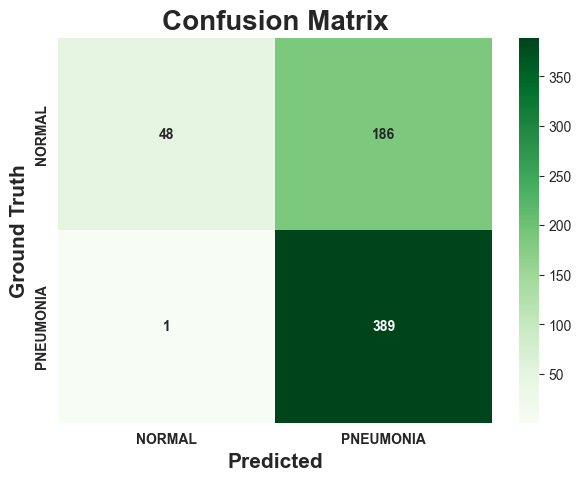


------------------------------ CLASSIFICATION CURVES ------------------------------



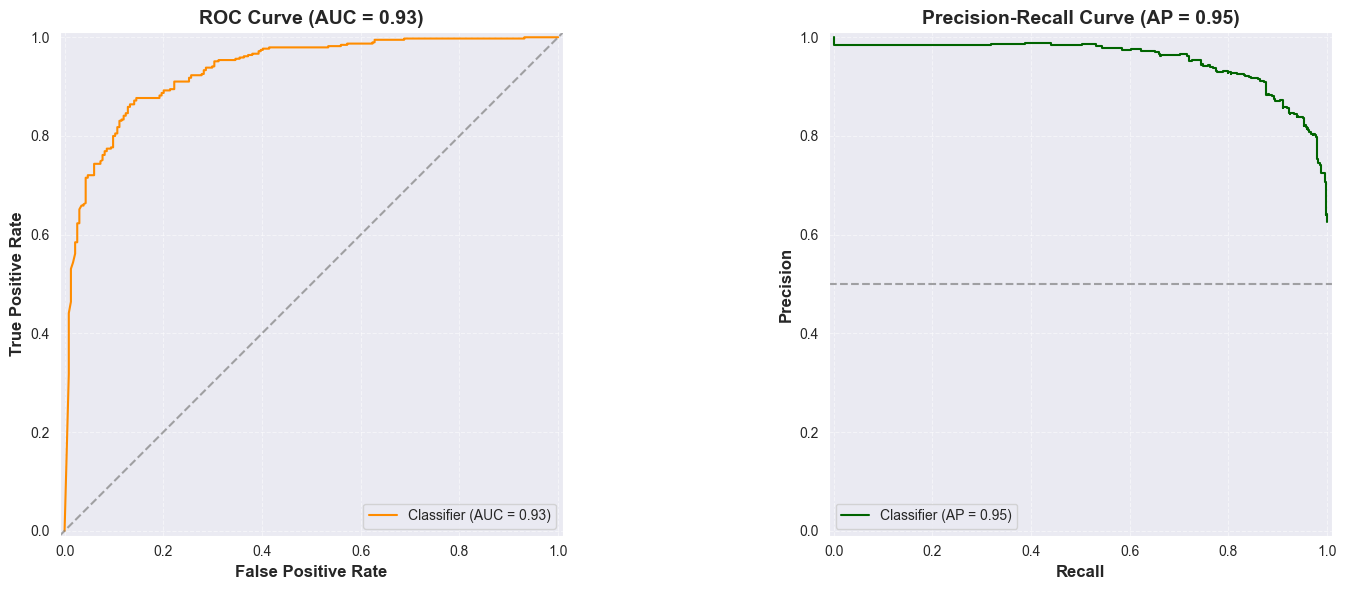


------------------------------ METRIC CURVES ------------------------------


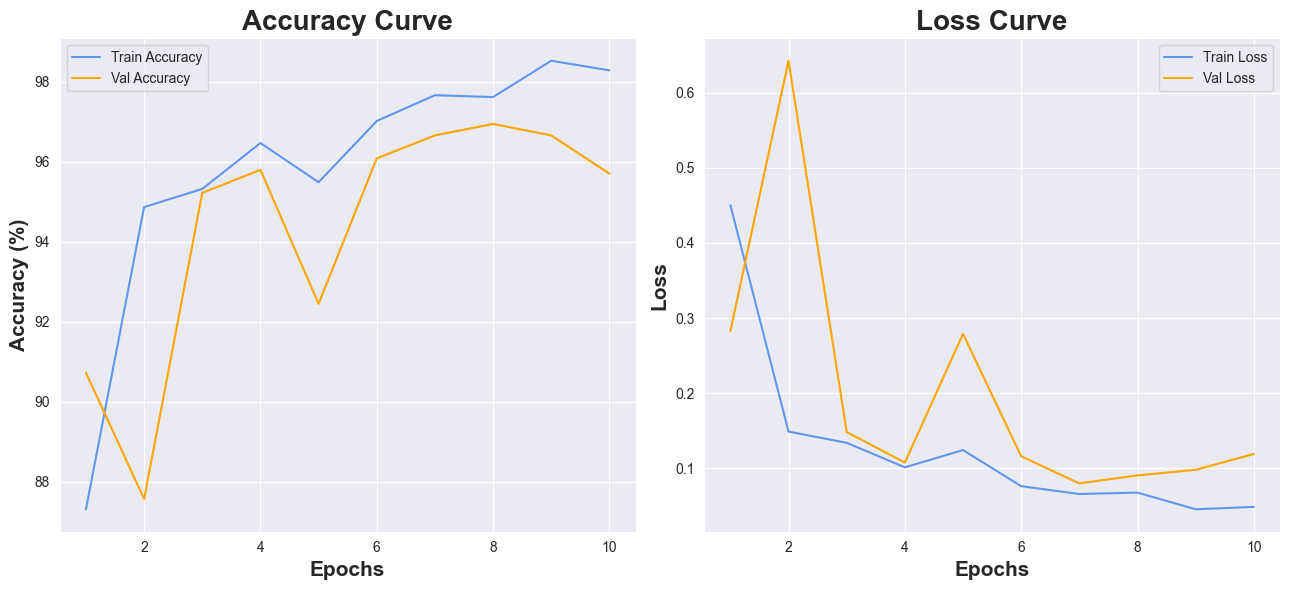



------------------------------ MODEL SAVED!! ------------------------------




In [17]:
print("MODEL ARCHITECTURE -->")
print(f"\t{type(model).__name__} ")
print("\nMODEL CONFIGURATION -->")
print(f"\tCRITERION: {type(criterion).__name__}")
print(f"\tOPTIMIZER: {type(optimizer).__name__}")
print(f"\tSCHEDULER: {type(scheduler).__name__}")
print("\nHYPERPARAMETERS -->")
print(f"\tBATCH_SIZE: {BATCH_SIZE}")
print(f"\tEPOCHS: {EPOCHS}")
print(f"\tLEARNING_RATE: {LEARNING_RATE}")
print(f"\tMAX_LR: {MAX_LEARNING_RATE}")
print(f"\tMIN_LR: {MIN_LEARNING_RATE}")
print(f"\tWEIGHT_DECAY: {WEIGHT_DECAY}")
print(f"\tNUM_CLASSES: {NUM_CLASSES}")
print(f"\tIMAGE_SIZE: {IMAGE_SIZE}")
print(f"\tCHANNELS: {IN_CHANNELS}")
print(f"\tDEVICE: {device}")

print("\n\n------------------------------ Starting MODEL.TRAIN...! ------------------------------")
last_epoch_dict, model_metrics, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_and_evaluate(model=model,
                                                                                                             train_loader=train_loader,
                                                                                                             val_loader=val_loader,
                                                                                                             test_loader=test_loader,
                                                                                                             test_set=test_dataset,
                                                                                                             epochs=EPOCHS,
                                                                                                             model_name="model1.pt")

#### **Load Model**

In [18]:
def load_model():
    checkpoint = torch.load("model1.pt")
    print("Loading model...\n")
    for key, value in checkpoint["metrics"].items():
        print(f"{key}: {value}")
    history = checkpoint["history"]
    model.load_state_dict(checkpoint["state_dict"], strict=False)
    print("\nModel loaded!!")
    return model, history

model, history = load_model()

Loading model...

epoch: 7
train_loss: 0.06768097846683485
train_acc: 97.61108456760631
val_loss: 0.09058539845952482
val_acc: 96.94072657743786

Model loaded!!


C:\Users\aniru\AppData\Local\Temp\ipykernel_14980\2437443849.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model1.pt")


#### **Visualize Predictions and Misclassified Samples**


------------------------------ PPREDICTIONS ------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1054316..2.1233294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1762059..1.893313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1762059..2.3002648].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1762059..1.9817808].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.123125..2.1587164].


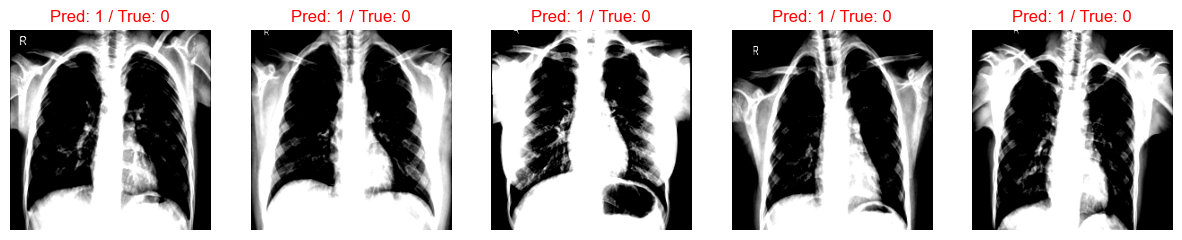



------------------------------ VISUALS OF SOME MISCLASSIFIED IMAGES ------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9638832..2.1233294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1762059..2.052555].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0700445..2.211797].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9461896..2.1233294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9108025..2.0348616].


Total misclassified: 28
Showing 5 random misclassified samples.


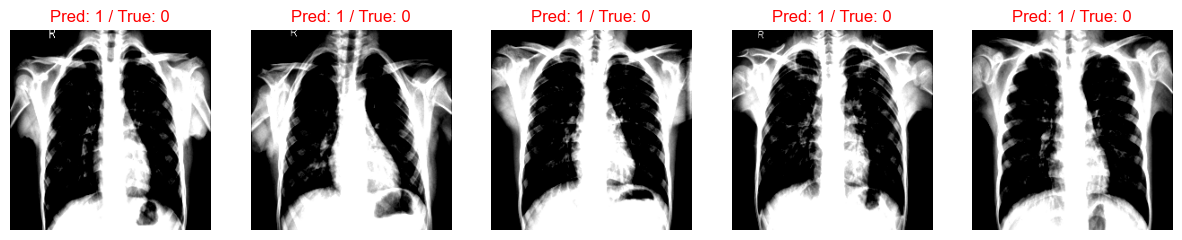

In [19]:
print("\n------------------------------ PPREDICTIONS ------------------------------")
visualize_predictions(model=model,
                      loader=test_loader)

print("\n\n------------------------------ VISUALS OF SOME MISCLASSIFIED IMAGES ------------------------------")
visualize_misclassified(model=model,
                        loader=test_loader,
                        device=device)

## **TASK 1.2**
Leverage the pre-trained ResNet-34 (the same CNN used in Task 1.1) model on the ImageNet and fine tune the model on the target X-ray images.

#### **Test Model Architecture**

In [20]:
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = True  # Fine-tune all layers

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.3), 
    nn.Linear(num_ftrs, NUM_CLASSES) 
)

model.to(device)

toy_input = torch.randn(BATCH_SIZE,
                        IN_CHANNELS,
                        IMAGE_SIZE,
                        IMAGE_SIZE).to(device)
output = model(toy_input).to(device)
print(f"Expected: torch.Size([BATCH_SIZE, NUM_CLASSES]) -> {BATCH_SIZE, NUM_CLASSES} \nActual: {output.shape}")  # Expected: torch.Size([BATCH_SIZE, NUM_CLASSES])

Expected: torch.Size([BATCH_SIZE, NUM_CLASSES]) -> (32, 2) 
Actual: torch.Size([32, 2])


#### **Model Architecture, Loss Function, Optimizer and Scheduler**

In [ ]:
## MODEL INIT, CRITERION and OPTIMIZER

model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).to(device)

for param in model.parameters():
    param.requires_grad = True  # Fine-tune all layers

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model.parameters(),
                        lr=LEARNING_RATE,
                        weight_decay=WEIGHT_DECAY)

total_steps = EPOCHS * len(train_loader)
cycle_steps = len(train_loader)
cycles = total_steps // cycle_steps

# scheduler = optim.lr_scheduler.CyclicLR(optimizer=optimizer,
#                                         base_lr=LEARNING_RATE,
#                                         max_lr=MAX_LEARNING_RATE,
#                                         step_size_down= cycle_steps * (cycles // 2),
#                                         step_size_up= cycle_steps * (cycles // 2),
#                                         mode="triangular")

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
                                                 T_max=EPOCHS,
                                                 eta_min=MIN_LEARNING_RATE)

print(f"\n\nModel architecture: ResNet34 - With Pretrained Weights from ImageNet ==> \n\n{model}")



Model architecture: ResNet34 - With Pretrained Weights from ImageNet ==> 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.

#### **Calling Main Function**

MODEL ARCHITECTURE -->
	ResNet with Pretrained Weights from ImageNet

MODEL CONFIGURATION -->
	CRITERION: CrossEntropyLoss
	OPTIMIZER: AdamW
	SCHEDULER: CosineAnnealingLR

HYPERPARAMETERS -->
	BATCH_SIZE: 32
	EPOCHS: 10
	LEARNING_RATE: 0.001
	MAX_LR: 0.001
	WEIGHT_DECAY: 0.0001
	NUM_CLASSES: 2
	IMAGE_SIZE: 224
	CHANNELS: 3
	DEVICE: cuda


------------------------------ Starting MODEL.TRAIN...! ------------------------------

Epoch 1/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:22<00:00,  1.45it/s]


	Train Loss: 0.4510, Train Accuracy: 82.37%
	Val Loss: 1.0690, Val Accuracy: 67.30%
	Current LR: 0.00012202456766718092

Epoch 2/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:22<00:00,  1.45it/s]


	Train Loss: 0.1451, Train Accuracy: 94.82%
	Val Loss: 0.3242, Val Accuracy: 88.24%
	Current LR: 0.0009140576474687131

Epoch 3/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:22<00:00,  1.46it/s]


	Train Loss: 0.1083, Train Accuracy: 95.94%
	Val Loss: 0.2064, Val Accuracy: 92.54%
	Current LR: 0.00028549663646839404

Epoch 4/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:22<00:00,  1.49it/s]


	Train Loss: 0.0669, Train Accuracy: 97.63%
	Val Loss: 0.0864, Val Accuracy: 95.79%
	Current LR: 0.0006890576474688027

Epoch 5/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:22<00:00,  1.45it/s]


	Train Loss: 0.0677, Train Accuracy: 97.73%
	Val Loss: 0.0718, Val Accuracy: 96.65%
	Current LR: 0.0005499999999999976

Epoch 6/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:18<00:00,  1.82it/s]


	Train Loss: 0.0593, Train Accuracy: 97.99%
	Val Loss: 0.1339, Val Accuracy: 94.17%
	Current LR: 0.0004109423525312565

Epoch 7/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:18<00:00,  1.81it/s]


	Train Loss: 0.0550, Train Accuracy: 98.21%
	Val Loss: 0.0964, Val Accuracy: 96.18%
	Current LR: 0.0008145033635317406

Epoch 8/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:18<00:00,  1.76it/s]


	Train Loss: 0.0431, Train Accuracy: 98.52%
	Val Loss: 0.0705, Val Accuracy: 97.04%
	Current LR: 0.00018594235253125823

Epoch 9/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


	Train Loss: 0.0339, Train Accuracy: 98.81%
	Val Loss: 0.0756, Val Accuracy: 97.61%
	Current LR: 0.0009779754323329473

Epoch 10/10
--------------------------------------------------


	Validating: 100%|██████████| 33/33 [00:22<00:00,  1.46it/s]


	Train Loss: 0.0362, Train Accuracy: 98.85%
	Val Loss: 0.1389, Val Accuracy: 96.08%
	Current LR: 0.0001


------------------------------ TESTING ------------------------------




TESTING: 100%|██████████| 20/20 [00:13<00:00,  1.51it/s]



------------------------------ CLASSIFICATION REPORT ------------------------------
               precision    recall  f1-score   support

      NORMAL       0.96      0.55      0.70       234
   PNEUMONIA       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.82      0.81       624

------------------------------ CONFUSION MATRIX ------------------------------



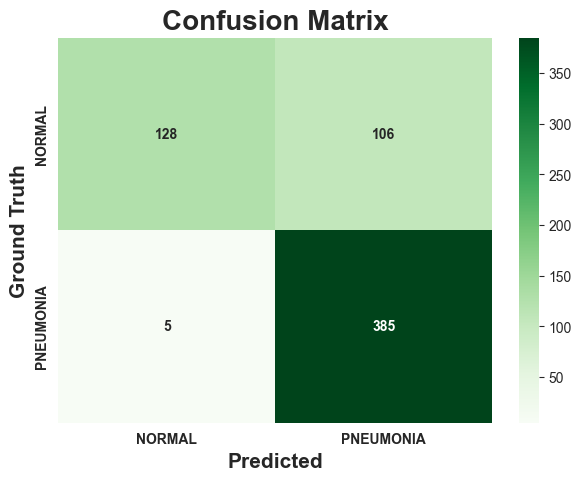


------------------------------ CLASSIFICATION CURVES ------------------------------



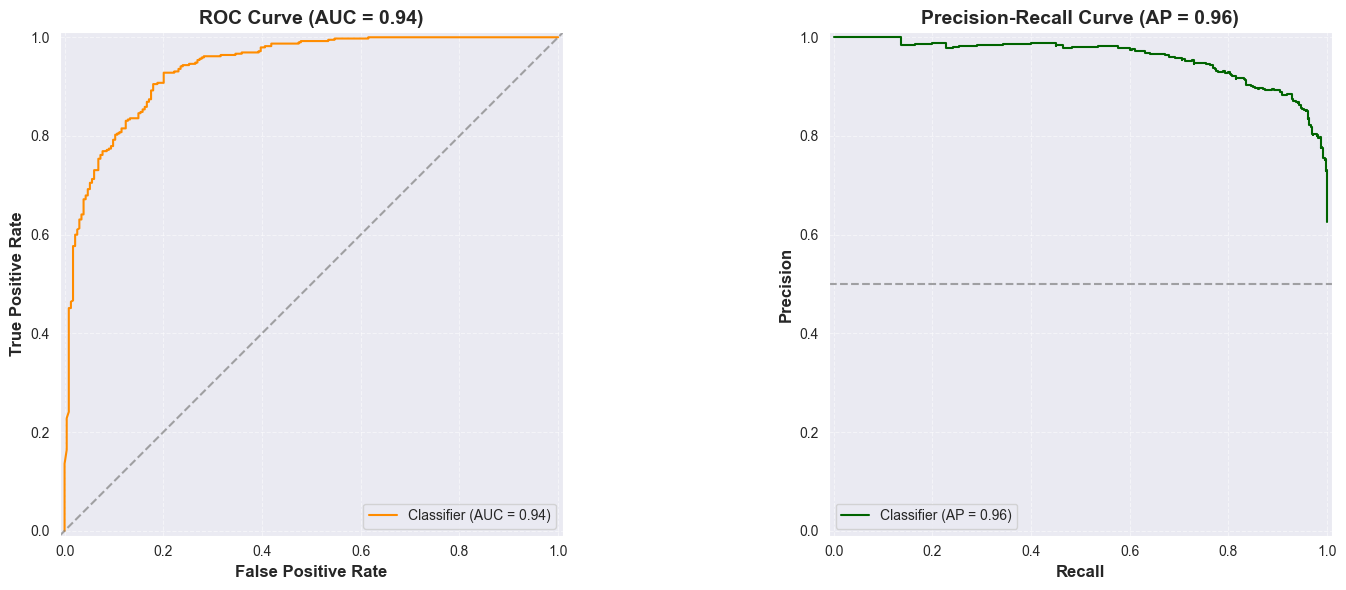


------------------------------ METRIC CURVES ------------------------------


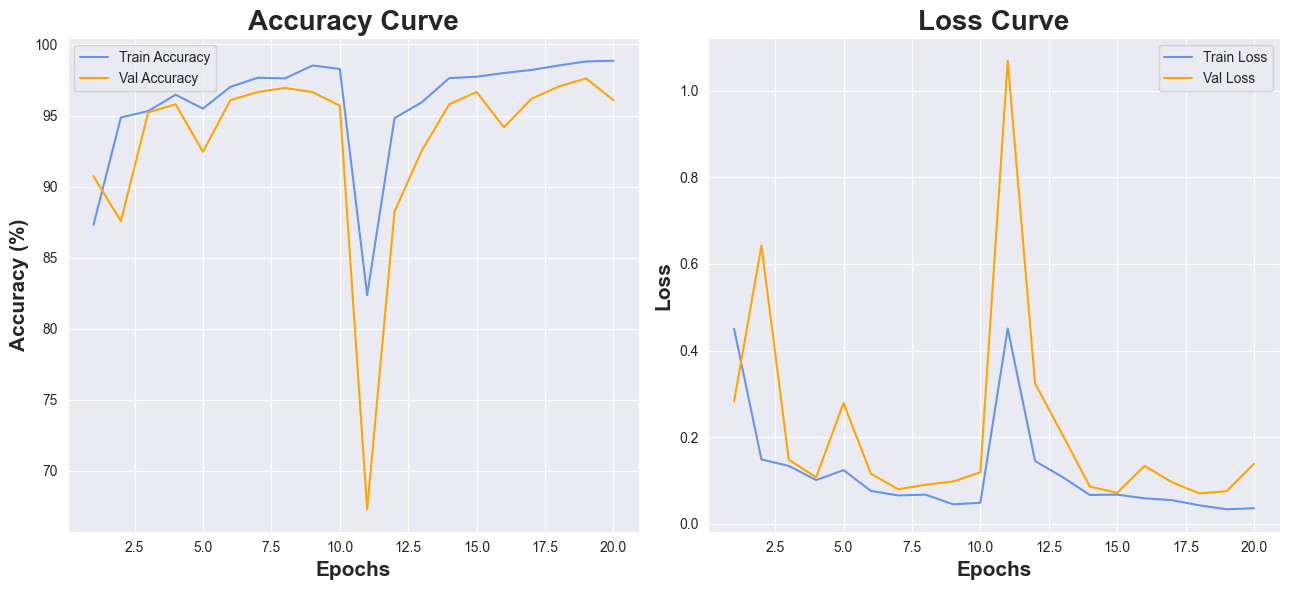



------------------------------ MODEL SAVED!! ------------------------------




In [22]:
print("MODEL ARCHITECTURE -->")
print(f"\t{type(model).__name__} with Pretrained Weights from ImageNet")
print("\nMODEL CONFIGURATION -->")
print(f"\tCRITERION: {type(criterion).__name__}")
print(f"\tOPTIMIZER: {type(optimizer).__name__}")
print(f"\tSCHEDULER: {type(scheduler).__name__}")
print("\nHYPERPARAMETERS -->")
print(f"\tBATCH_SIZE: {BATCH_SIZE}")
print(f"\tEPOCHS: {EPOCHS}")
print(f"\tLEARNING_RATE: {LEARNING_RATE}")
print(f"\tMAX_LR: {MAX_LEARNING_RATE}")
print(f"\tWEIGHT_DECAY: {WEIGHT_DECAY}")
print(f"\tNUM_CLASSES: {NUM_CLASSES}")
print(f"\tIMAGE_SIZE: {IMAGE_SIZE}")
print(f"\tCHANNELS: {IN_CHANNELS}")
print(f"\tDEVICE: {device}")

print("\n\n------------------------------ Starting MODEL.TRAIN...! ------------------------------")
last_epoch_dict, model_metrics, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_and_evaluate(model=model,
                                                                                                             train_loader=train_loader,
                                                                                                             val_loader=val_loader,
                                                                                                             test_loader=test_loader,
                                                                                                             test_set=test_dataset,
                                                                                                             epochs=EPOCHS,
                                                                                                             model_name="model2.pt")

#### **Visualize Predictions and Misclassified Samples**


------------------------------ PPREDICTIONS ------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1585124..2.2825713].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1762059..1.9994744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.052351..1.9110066].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1762059..1.7163774].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9461896..2.17641].


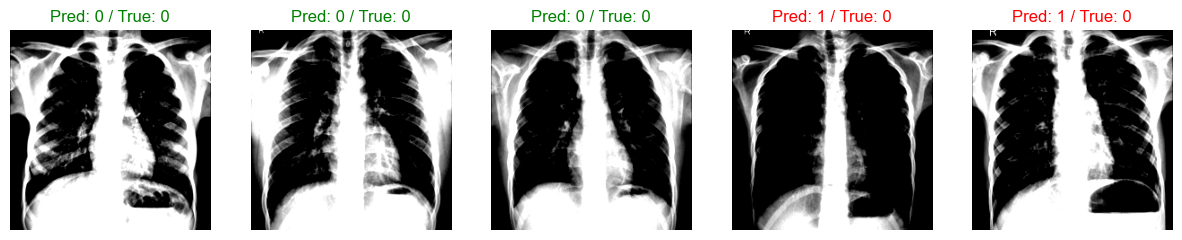



------------------------------ VISUALS OF SOME MISCLASSIFIED IMAGES ------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1762059..1.7163774].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.123125..1.7871517].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1762059..1.9817808].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.123125..2.1587164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1762059..2.3179584].


Total misclassified: 15
Showing 5 random misclassified samples.


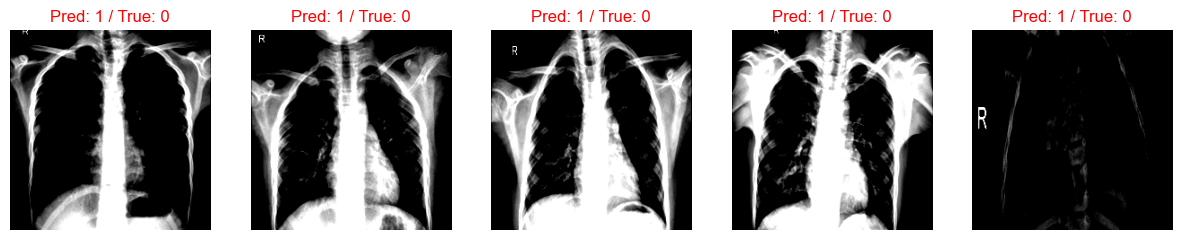

In [27]:
print("\n------------------------------ PPREDICTIONS ------------------------------")
visualize_predictions(model=model,
                      loader=test_loader)

print("\n\n------------------------------ VISUALS OF SOME MISCLASSIFIED IMAGES ------------------------------")
visualize_misclassified(model=model,
                        loader=test_loader,
                        device=device)

#### **Load Model**

In [24]:
def load_model():
    checkpoint = torch.load("model2.pt")
    print("Loading model...\n")
    for key, value in checkpoint["metrics"].items():
        print(f"{key}: {value}")
    history = checkpoint["history"]
    model.load_state_dict(checkpoint["state_dict"], strict=False)
    print("\nModel loaded!!")
    return model, history

model, history = load_model()

C:\Users\aniru\AppData\Local\Temp\ipykernel_14980\1524227259.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model2.pt")


Loading model...

epoch: 8
train_loss: 0.033879765665748705
train_acc: 98.80554228380315
val_loss: 0.0755909487149135
val_acc: 97.60994263862332

Model loaded!!
